| Name         | ID         |
|--------------|------------|
| MAO Sedtha   | e20211621  |


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# from google.colab import files
# uploaded = files.upload()


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
import pandas as pd
data_train = pd.read_csv('/content/kh_char_test.csv', header=None, na_filter=False)
data_test = pd.read_csv('/content/kh_char_test.csv', header=None, na_filter=False)

In [ ]:
data_train.head()

,0,1,2,3,4,5,6,7,8,9,...,2295,2296,2297,2298,2299,2300,2301,2302,2303,2304
0,TA,215,215,220,220,230,230,230,230,225,...,170,170,180,185,180,180,190,200,210,200
1,NA,231,235,243,243,231,227,231,235,235,...,215,211,227,231,227,235,227,223,223,223
2,CHA,235,229,219,229,238,238,229,232,238,...,187,183,180,193,193,193,200,196,196,190
3,CHA,243,249,255,249,237,237,226,226,226,...,255,255,249,243,237,226,220,226,226,243
4,KHA,236,225,214,214,204,167,112,182,244,...,244,251,255,255,255,255,247,247,251,247


In [ ]:
data_train.value_counts(0)

,count
0,
TA,3608
NGO,3437
CHA,2348
DA,1145
KO,994
NA,966
KHA,826
CHHA,309
CHHO,139


In [ ]:
data_train.shape

(13898, 2305)

In [ ]:
import numpy as np
data_train = data_train.replace('', 0)
data_test  = data_test.replace('', 0)

In [ ]:
x_train = data_train.iloc[:, 1:].to_numpy().astype(float)
y_train = data_train.iloc[:, 0].to_numpy()  # use numpy array for indexing
x_test = data_test.iloc[:, 1:].to_numpy().astype(float)
y_test = data_test.iloc[:, 0].to_numpy()

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_encode_train = encoder.fit_transform(y_train)
y_encode_test = encoder.fit_transform(y_test)

In [ ]:
# Convert labels to numpy array
y_train = np.array(y_encode_train)

# 80% train, 20% validation, stratified
x_train_split, x_val, y_train_split, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print("Train shape:", x_train_split.shape, y_train_split.shape)
print("Validation shape:", x_val.shape, y_val.shape)


Train shape: (11118, 2304) (11118,)
Validation shape: (2780, 2304) (2780,)


np.int64(0)

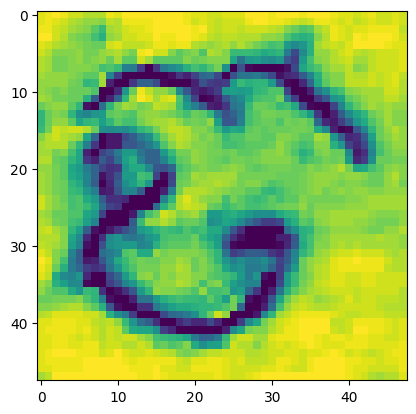

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(x_train[3].reshape(48,48))
y_train[3]

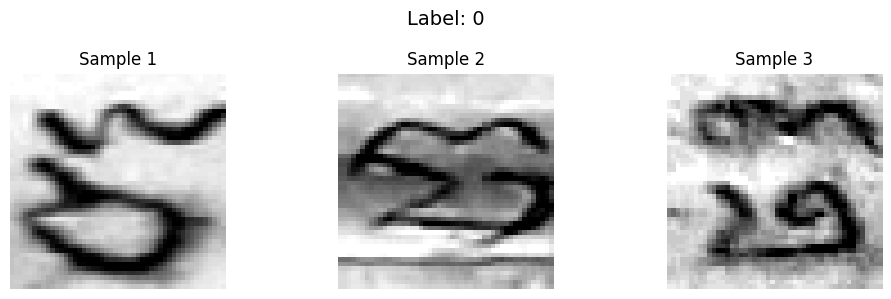

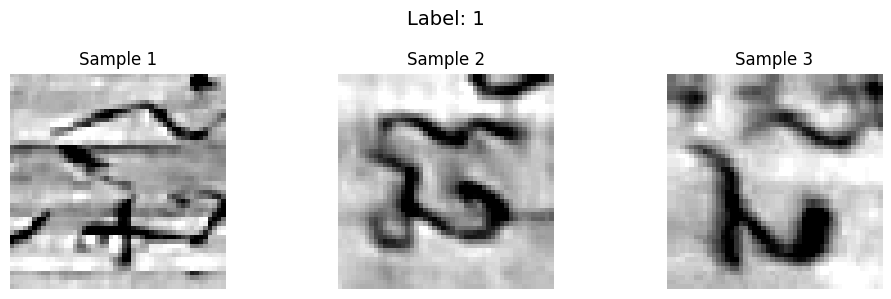

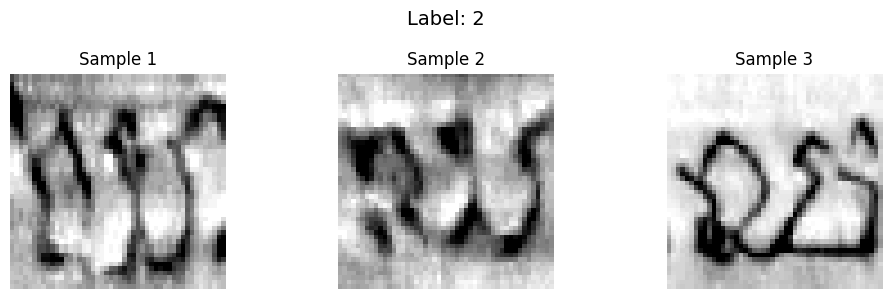

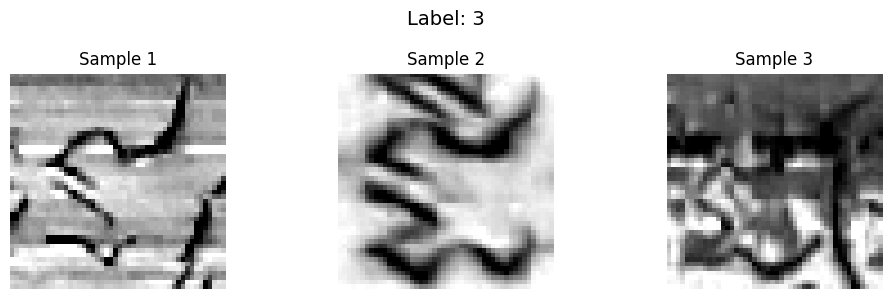

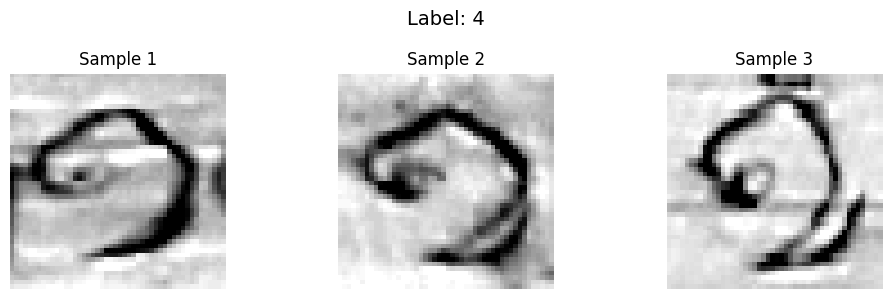

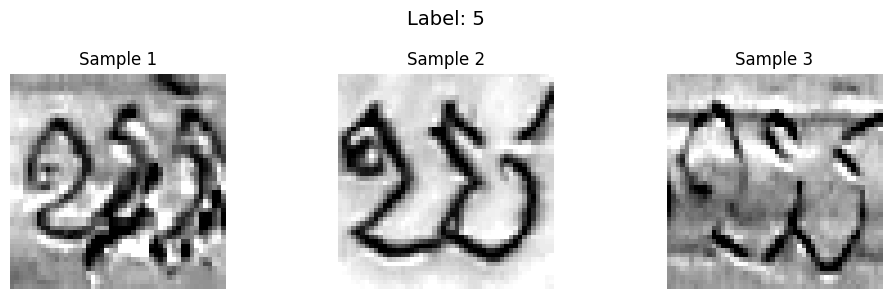

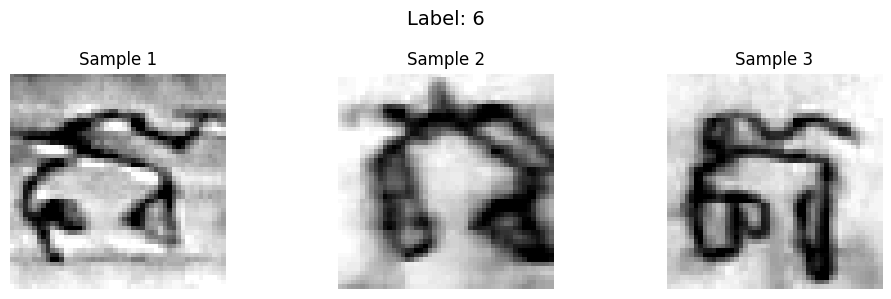

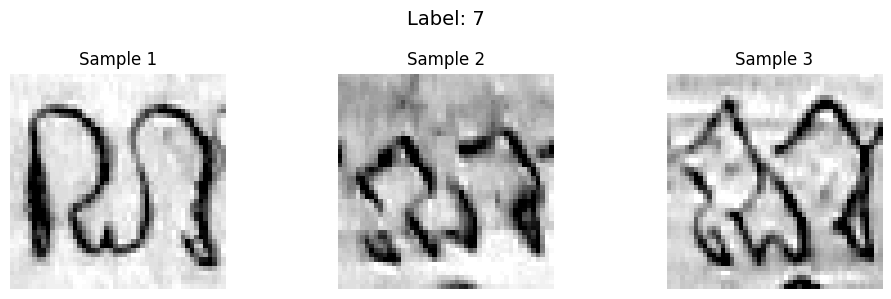

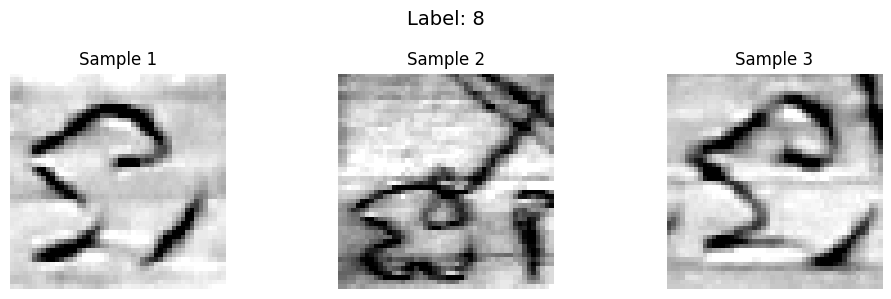

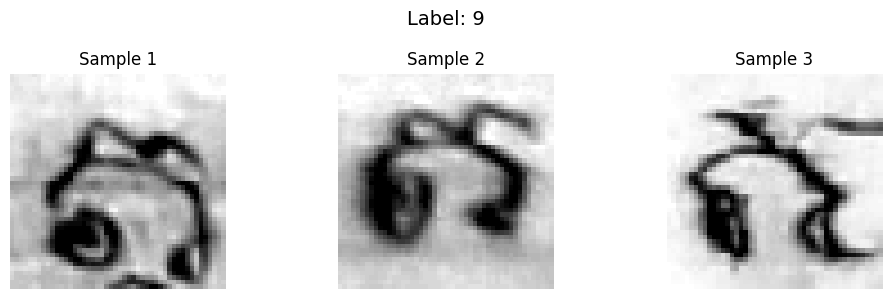

In [ ]:

unique_labels = np.unique(y_train)

# Loop through labels
for label in unique_labels:
    # Find indices for this label
    idx = np.flatnonzero(y_train == label)

    if len(idx) < 3:
        print(f"Skipping label {label} (only {len(idx)} samples)")
        continue

    # Randomly choose 3 images
    selected = np.random.choice(idx, 3, replace=False)

    # Plot 3 images side by side
    fig, axes = plt.subplots(1, 3, figsize=(10, 3))
    fig.suptitle(f"Label: {label}", fontsize=14)

    for i, sample_idx in enumerate(selected):
        img = x_train[sample_idx].reshape(48, 48)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Sample {i+1}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
from torch.utils.data import Dataset, DataLoader
class KhDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = torch.tensor(images, dtype=torch.float32)   # convert to float tensor
        self.labels = torch.tensor(labels, dtype=torch.long)      # convert labels to long
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx].reshape(1, 48, 48)  # add channel dimension
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label


In [ ]:
import torch

batch_size = 64

train_dataset = KhDataset(x_train_split, y_train_split)
val_dataset   = KhDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("Number of batches (train):", len(train_loader))
print("Number of batches (val):", len(val_loader))


Number of batches (train): 174
Number of batches (val): 44


In [ ]:
images, labels = next(iter(train_loader))
print("Batch images shape:", images.shape)  # [batch_size, 1, 48, 48]
print("Batch labels shape:", labels.shape)


Batch images shape: torch.Size([64, 1, 48, 48])
Batch labels shape: torch.Size([64])


In [ ]:
import  torch
import torch.nn as nn
import torch.optim as optim

class MyModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(2304, 392)
    self.fc2 = nn.Linear(392, 196)
    self.fc3 = nn.Linear(196, 98)
    self.fc4 = nn.Linear(98, 10)
    self.relu = nn.ReLU()

  def forward(self, x):
      x = self.fc1(x)
      x = self.relu(x)

      x = self.fc2(x)
      x = self.relu(x)

      x = self.fc3(x)
      x = self.relu(x)

      x = self.fc4(x)
      return x



In [ ]:
x = torch.rand(20,2304)
zfnet = MyModel()
output = zfnet(x)
print(output.shape)  # Expected output: torch.Size([20, 10])

torch.Size([20, 10])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Model
model = MyModel().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training settings
num_epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# NEW: Store iteration losses
iteration_losses = []
iterations = []

for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.view(images.size(0), -1).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Store iteration loss
        iteration_losses.append(loss.item())
        iterations.append(epoch * len(train_loader) + i + 1)

        # Print iteration progress
        if (i + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Iteration [{i+1}/{len(train_loader)}], "
                  f"Batch Loss: {loss.item():.4f}")

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # --- Validation ---
    model.eval()
    val_running_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.view(images.size(0), -1).to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")



Using device: cpu
Epoch [1/100], Iteration [10/174], Batch Loss: 50.7615
Epoch [1/100], Iteration [20/174], Batch Loss: 11.1280
Epoch [1/100], Iteration [30/174], Batch Loss: 7.3378
Epoch [1/100], Iteration [40/174], Batch Loss: 1.6453
Epoch [1/100], Iteration [50/174], Batch Loss: 2.6240
Epoch [1/100], Iteration [60/174], Batch Loss: 2.2275
Epoch [1/100], Iteration [70/174], Batch Loss: 1.6559
Epoch [1/100], Iteration [80/174], Batch Loss: 1.9102
Epoch [1/100], Iteration [90/174], Batch Loss: 1.0756
Epoch [1/100], Iteration [100/174], Batch Loss: 1.2251
Epoch [1/100], Iteration [110/174], Batch Loss: 0.7856
Epoch [1/100], Iteration [120/174], Batch Loss: 0.8033
Epoch [1/100], Iteration [130/174], Batch Loss: 1.0194
Epoch [1/100], Iteration [140/174], Batch Loss: 0.9849
Epoch [1/100], Iteration [150/174], Batch Loss: 0.7664
Epoch [1/100], Iteration [160/174], Batch Loss: 0.9681
Epoch [1/100], Iteration [170/174], Batch Loss: 0.9073
Epoch [1/100] Train Loss: 5.7929, Acc: 0.5118 | Val Lo

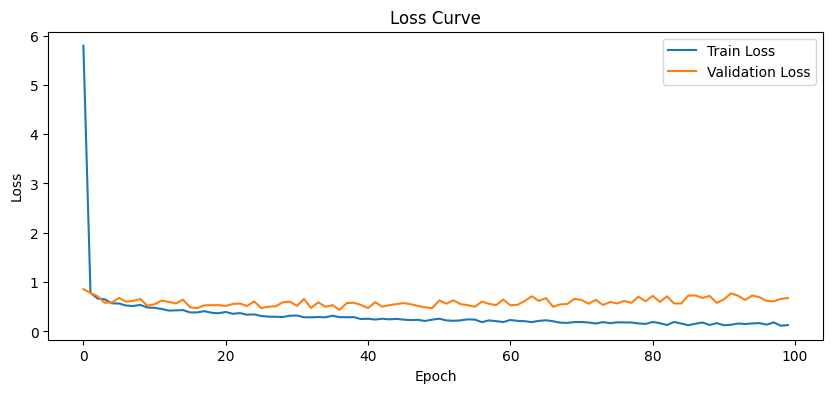

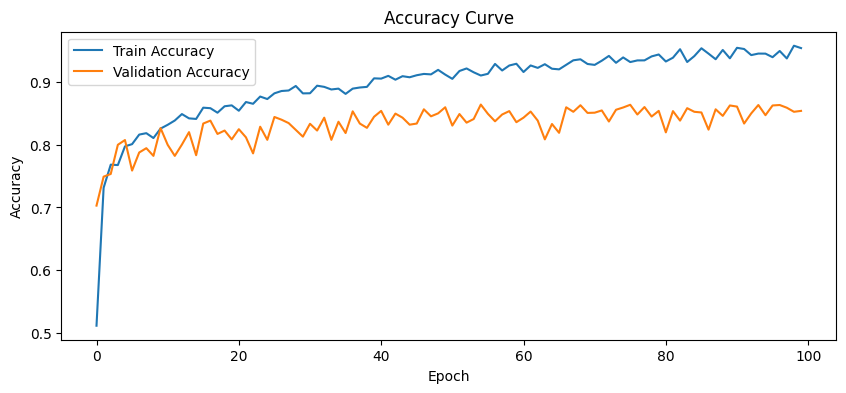

In [ ]:
# Loss
plt.figure(figsize=(10,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

# Accuracy
plt.figure(figsize=(10,4))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.show()


In [ ]:
# # Plotting the graphs
# plt.figure(figsize=(15, 5))

# # Plot 1: Epoch vs Loss
# plt.subplot(1, 2, 1)
# plt.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Train Loss', linewidth=2)
# plt.plot(range(1, num_epochs + 1), val_losses, 'r-', label='Validation Loss', linewidth=2)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Epoch vs Loss')
# plt.legend()
# plt.grid(True, alpha=0.3)

# # Plot 2: Iteration vs Loss
# plt.subplot(1, 2, 2)
# plt.plot(iterations, iteration_losses, 'g-', alpha=0.7, linewidth=1)
# plt.xlabel('Iteration')
# plt.ylabel('Batch Loss')
# plt.title('Iteration vs Batch Loss')
# plt.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

In [ ]:
data_test = KhDataset(x_test, y_encode_test)
test_loader = DataLoader(data_test, batch_size=64, shuffle=True)

In [ ]:
model.eval()  # set model to evaluation mode
val_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for b_x, b_y in test_loader:
        b_x, b_y = b_x.to(device), b_y.to(device)
        b_x = b_x.view(b_x.size(0), -1)  # flatten to 2304
        b_output = model(b_x)
        loss = criterion(b_output, b_y)
        val_loss += loss.item() * b_x.size(0)  # multiply by batch size

        _, predicted = torch.max(b_output, 1)
        total += b_y.size(0)
        correct += (predicted == b_y).sum().item()

avg_val_loss = val_loss / total
accuracy = 100 * correct / total

print(f'Test Loss: {avg_val_loss:.8f}, Accuracy: {accuracy:.2f}%')


Test Loss: 0.25057842, Accuracy: 92.96%


In [ ]:
torch.save(model.state_dict(), "/content/khmer_model_weights2.pth")


In [ ]:
# Recreate the model architecture first
model = MyModel()
# Load weights
model.load_state_dict(torch.load("/content/khmer_model_weights2.pth"))
model.eval()


MyModel(
  (fc1): Linear(in_features=2304, out_features=392, bias=True)
  (fc2): Linear(in_features=392, out_features=196, bias=True)
  (fc3): Linear(in_features=196, out_features=98, bias=True)
  (fc4): Linear(in_features=98, out_features=10, bias=True)
  (relu): ReLU()
)

In [ ]:
model.eval()  # set model to evaluation mode
val_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for b_x, b_y in test_loader:
        b_x, b_y = b_x.to(device), b_y.to(device)
        b_x = b_x.view(b_x.size(0), -1)  # flatten to 2304
        b_output = model(b_x)
        loss = criterion(b_output, b_y)
        val_loss += loss.item() * b_x.size(0)  # multiply by batch size

        _, predicted = torch.max(b_output, 1)
        total += b_y.size(0)
        correct += (predicted == b_y).sum().item()

avg_val_loss = val_loss / total
accuracy = 100 * correct / total

print(f'Test Loss: {avg_val_loss:.8f}, Accuracy: {accuracy:.2f}%')


Test Loss: 0.25057843, Accuracy: 92.96%


# SUMMARY OF STRUCTURE CNN

In [ ]:
from torchsummary import summary
summary(model,input_size=(1,2304))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 392]         903,560
              ReLU-2               [-1, 1, 392]               0
            Linear-3               [-1, 1, 196]          77,028
              ReLU-4               [-1, 1, 196]               0
            Linear-5                [-1, 1, 98]          19,306
              ReLU-6                [-1, 1, 98]               0
            Linear-7                [-1, 1, 10]             990
Total params: 1,000,884
Trainable params: 1,000,884
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.01
Params size (MB): 3.82
Estimated Total Size (MB): 3.84
----------------------------------------------------------------


# Testing With Some Image

In [ ]:
label_mapping = dict(zip(encoder.classes_, range(len(encoder.classes_))))
label_mapping


{'CHA': 0,
 'CHHA': 1,
 'CHHO': 2,
 'DA': 3,
 'KHA': 4,
 'KHO': 5,
 'KO': 6,
 'NA': 7,
 'NGO': 8,
 'TA': 9}

In [ ]:
from PIL import Image
import torch.nn.functional as F
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.Grayscale(1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))

])

In [ ]:
def preprocess_image(image_path):
    img = Image.open(image_path).convert("L")  # convert to grayscale
    img = img.resize((48,48))                  # resize if needed
    img_array = np.array(img, dtype=np.float32)
    img_array = img_array.reshape(1, 1, 48, 48)  # [batch, channel, H, W]
    img_tensor = torch.tensor(img_array)
    img_tensor = img_tensor.view(1, -1)        # flatten to 2304
    return img_tensor.to(device)


In [ ]:
image_path = "/content/Screenshot 2025-11-18 092454.png"
img_tensor = preprocess_image(image_path)
idx_to_label = {v: k for k, v in label_mapping.items()}

with torch.no_grad():
    output = model(img_tensor)
    _, predicted_idx = torch.max(output, 1)
    predicted_label = idx_to_label[predicted_idx.item()]

print("Predicted label:", predicted_label)


Predicted label: CHA


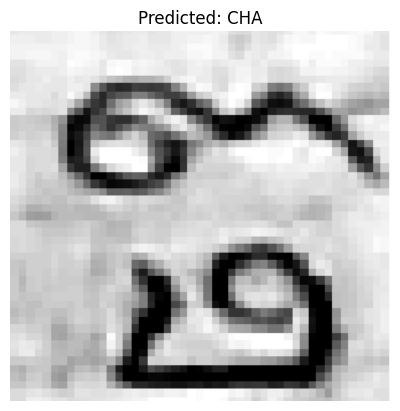

In [ ]:
import matplotlib.pyplot as plt

img = Image.open(image_path).convert("L")
plt.imshow(img, cmap="gray")
plt.title(f"Predicted: {predicted_label}")
plt.axis("off")
plt.show()


Predicted class index: 9
Predicted Khmer character: TA
Prediction confidence: 51.85%


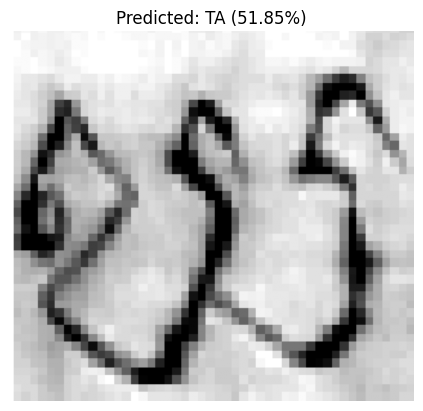

In [ ]:
with torch.no_grad():
    output = model(img_tensor)
    probabilities = F.softmax(output, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()
    confidence = probabilities[0, predicted_class].item()

predicted_label = idx_to_label[predicted_class]

print(f"Predicted class index: {predicted_class}")
print(f"Predicted Khmer character: {predicted_label}")
print(f"Prediction confidence: {confidence * 100:.2f}%")

# Display image with prediction
plt.imshow(img, cmap="gray")
plt.axis('off')
plt.title(f"Predicted: {predicted_label} ({confidence*100:.2f}%)")
plt.show()

In [ ]:
# Manual label to index mapping
label_to_idx = {
    'TA': 0,    # ត
    'NGO': 1,   # ង
    'CHA': 2,   # ច
    'DA': 3,    # ដ
    'KO': 4,    # ក
    'NA': 5,    # ណ
    'KHA': 6,   # ខ
    'CHHA': 7,  # ឆ
    'CHHO': 8,  # ឈ
    'KHO': 9    # ឃ
}

# Reverse mapping index → label
idx_to_label = {v: k for k, v in label_to_idx.items()}

# Optional: map label → Khmer character
label_to_char = {
    'TA': 'ត',
    'NGO': 'ង',
    'CHA': 'ច',
    'DA': 'ដ',
    'KO': 'ក',
    'NA': 'ណ',
    'KHA': 'ខ',
    'CHHA': 'ឆ',
    'CHHO': 'ឈ',
    'KHO': 'ឃ'
}

# Example usage
pred_idx = 2
pred_label = idx_to_label[pred_idx]      # e.g., 'CHA'
pred_char = label_to_char[pred_label]    # 'ច'

print(f"Predicted Label: {pred_label}, Character: {pred_char}")


Predicted Label: CHA, Character: ច
